In [7]:
import matplotlib.pyplot as plt
import numpy as np
import sys, pathlib

# Project-1 folder (parent of this Notebooks/ folder)
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

# Figures folder
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale

# --- Project-wide experiment config (used in ALL notebooks) ---

# Data settings
N_SAMPLES   = 300     # number of samples
NOISE_SD    = 0.3     # noise standard deviation
SEED_DATA   = 42      # data generation
SEED_SPLIT  = 42      # train/test split (split_and_scale uses this)
DEG_MAX     = 15      # max polynomial degree for features
P_FIXED     = 15      # fixed polynomial degree for regularization experiments
TEST_SIZE   = 0.20    # train/test split size


# Regularization grids
LAM_GRID_RIDGE = np.logspace(-6, 1, 40)  # wider range for ridge
LAM_GRID_LASSO = np.logspace(-6, 0, 60)  # less range for LASSO

# Optimizer settings
ETA_FULL   = 5e-3     # full-batch GD steps
ITERS_FULL = 5000     # full-batch GD iterations
LAM_RIDGE  = 0.0203   # Taken from ridge experiments (02_Ridge_lambda.ipynb) best lambda for degree 15
BETA = 0.3    # momentum parameter
B1 = 0.9    # Adam parameter
B2 = 0.999  # Adam parameter
EPS = 1e-8  # Adam parameter
RHO = 0.99  # Adadelta parameter

# Mini-batch SGD
EPOCHS_MB    = 25     # passes over data
BATCH_SIZE   = 64     # minibatch size
ETA_MB_OLS   = 1e-2   # for OLS, can be larger
ETA_MB_RIDGE = 1e-2   # for ridge, need to tune
SEED_MB      = 42     # minibatch shuffle

# Resampling
B = 200 # bootstrap samples

# --- Generate data explicitly---
x, y = make_data(n=N_SAMPLES, noise_sd=NOISE_SD, seed=SEED_DATA)
X_full = build_features(x, degree=DEG_MAX, include_bias=False)


#X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mean = split_and_scale(X_full, y, test_size=TEST_SIZE, random_state=SEED_SPLIT)



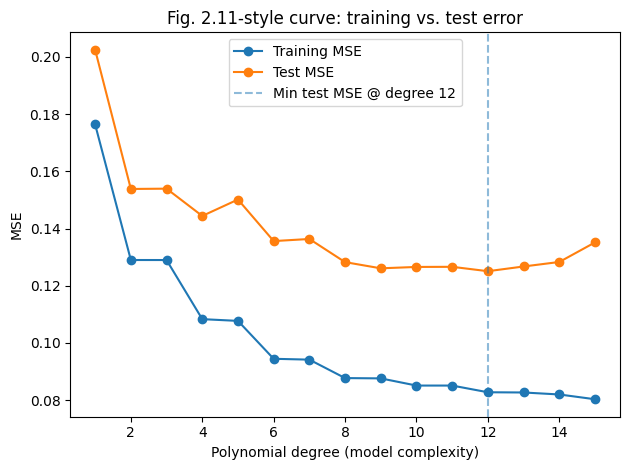

In [ ]:
from Code.models import fit_ols 
from Code.metrics import mse, r2
from Code.models import predict_centered, fit_ridge, fit_ols, sweep_degree
from Code.resampling import bias_variance_from_preds, bootstrap_predictions

# ===== Fig 2.11-style: train & test MSE vs. model complexity =====
rng = np.random.default_rng(SEED_DATA) 

# one fixed split, centered y 
split = lambda X,Y: split_and_scale(X, Y, test_size=TEST_SIZE, random_state=SEED_SPLIT, center_y=True)
X_tr_s, X_te_s, y_tr_c, y_te, _, y_mean = split(X_full, y)

train_mse, test_mse = [], []
degrees = list(range(1, DEG_MAX + 1))

for p in degrees:
    Xtr_p = X_tr_s[:, :p]
    Xte_p = X_te_s[:, :p]

    theta   = fit_ols(Xtr_p, y_tr_c)                     # fit on centered y
    yhat_tr = predict_centered(Xtr_p, theta, y_mean)   # (n,)
    yhat_te = predict_centered(Xte_p, theta, y_mean)   # (n,)

    # ensure targets are 1-D to match predictions
    y_tr_uncentered = (y_tr_c + y_mean).ravel()
    y_te_1d         = y_te.ravel()

    train_mse.append(mse(y_tr_uncentered, yhat_tr))
    test_mse.append(mse(y_te_1d,        yhat_te))

plt.figure()
plt.plot(degrees, train_mse, marker="o", label="Training MSE")
plt.plot(degrees, test_mse,  marker="o", label="Test MSE")
best_idx = int(np.argmin(test_mse))
plt.axvline(degrees[best_idx], linestyle="--", alpha=0.5,
            label=f"Min test MSE @ degree {degrees[best_idx]}")
plt.xlabel("Polynomial degree (model complexity)")
plt.ylabel("MSE")
plt.title("Fig. 2.11-style curve: training vs. test error")
plt.legend()
plt.tight_layout()


[0.0004183432345262092, 0.0010269214446988375, 0.001474755648736527, 0.0016939841994025563, 0.002063382199830922, 0.002264616949150709, 0.0028658615701264195, 0.0029464817252731496, 0.003383320057512418, 0.003777543378709769, 0.004217719037352564, 0.004519770724540369, 0.005061711334078135, 0.005533736939819047, 0.00534516029568773]


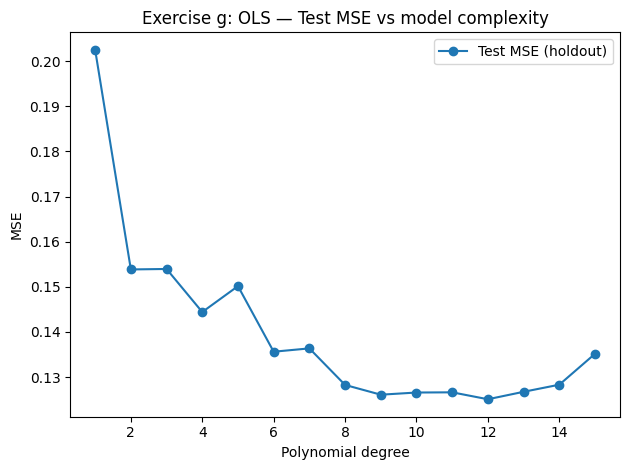

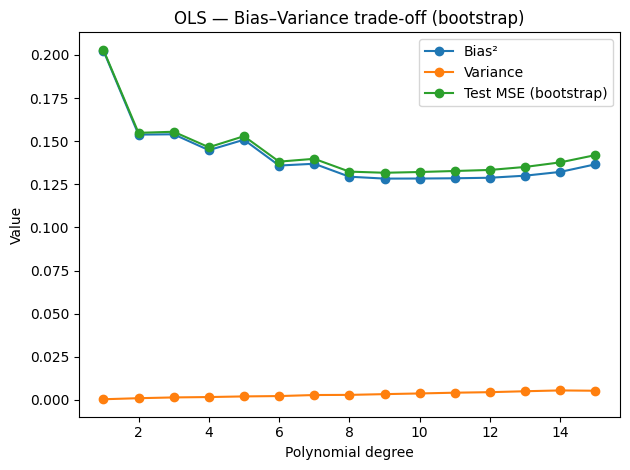

In [ ]:
# ----- data & features -----
rng = np.random.default_rng(SEED_DATA) 

split = lambda X,Y: split_and_scale(X, Y, test_size=TEST_SIZE, random_state=SEED_SPLIT, center_y=True)

# ===== OLS test MSE vs degree  =====
degrees, mses, r2s, norms = sweep_degree(X_full, y, split_func=split, deg_max=DEG_MAX)

plt.figure()
plt.plot(degrees, mses, marker="o", label="Test MSE (holdout)")
plt.xlabel("Polynomial degree"); plt.ylabel("MSE")
plt.title("Exercise g: OLS — Test MSE vs model complexity")
plt.legend(); plt.tight_layout() 

plt.savefig(fig_dir / "ols_mse_degree.png", dpi=300, bbox_inches="tight")

# ===== OLS bias–variance with bootstrap =====
# Get a single train/test split once, then reuse for all degrees
X_tr_s, X_te_s, y_tr_c, y_te, _, y_mean = split(X_full, y)


bias2_list, var_list, mse_te_list = [], [], []

for p in range(1, DEG_MAX + 1):
    # Bootstrap predictions: P shape is (B, n_test)
    P = bootstrap_predictions(
        fit_fn=fit_ols,                 # closed-form OLS on centered y
        pred_fn=predict_centered,     # adds back y_mean
        Xtr_s=X_tr_s[:, :p],
        ytr_c=y_tr_c,
        Xte_s=X_te_s[:, :p],
        y_mean=y_mean,
        B=B, seed=SEED_DATA
    )
    bias2, var, mse = bias_variance_from_preds(P, y_true=y_te)
    bias2_list.append(bias2)
    var_list.append(var)
    mse_te_list.append(mse)

plt.figure()
plt.plot(range(1, DEG_MAX+1), bias2_list, marker="o", label="Bias²")
plt.plot(range(1, DEG_MAX+1), var_list,   marker="o", label="Variance")
plt.plot(range(1, DEG_MAX+1), mse_te_list,marker="o", label="Test MSE (bootstrap)")
plt.xlabel("Polynomial degree"); plt.ylabel("Value")
plt.title("OLS — Bias–Variance trade-off (bootstrap)")
plt.legend(); plt.tight_layout()
print(var_list)

plt.savefig(fig_dir / "ols_bias_variance.png", dpi=300, bbox_inches="tight")